In [2]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -qr requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.
/kaggle/working/yolov5


In [ ]:
%cd yolov5

In [3]:
# to display images
from IPython.display import Image, clear_output
import torch
from yolov5 import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-230-g53efd07 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5016.7/8062.4 GB disk)


In [4]:
# configure .yaml file to guide the model for training
yaml_text = """train: /kaggle/input/traffic-detection-project/train/images
val: /kaggle/input/traffic-detection-project/valid/images
test: /kaggle/input/traffic-detection-project/test/test/images

nc: 5
names: ['bicycle', 'bus', 'car', 'motorbike', 'person']"""

with open("data/data.yaml", 'w') as file:
    file.write(yaml_text)

%cat data/data.yaml

train: /kaggle/input/traffic-detection-project/train/images
val: /kaggle/input/traffic-detection-project/valid/images
test: /kaggle/input/traffic-detection-project/test/test/images

nc: 5
names: ['bicycle', 'bus', 'car', 'motorbike', 'person']

In [5]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [6]:
%%writetemplate models/custom_yolov5m.yaml
# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [7]:
# train yolov5s on custom data for 100 epochs
# time its performance
# we are going to using pre-trained weights from yolov5.pt model
from datetime import datetime
start = datetime.now()
!python train.py --img 448 --batch 32 --epochs 20 --data data/data.yaml --cfg models/custom_yolov5m.yaml --weights yolov5m.pt --name yolov5m_results  --cache
end = datetime.now()

train: weights=yolov5m.pt, cfg=models/custom_yolov5m.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=32, imgsz=448, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5m_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-230-g53efd07 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, h

In [8]:
print("Runtime =",end-start)

Runtime = 0:21:57.279284


In [9]:
import matplotlib.pyplot as plt

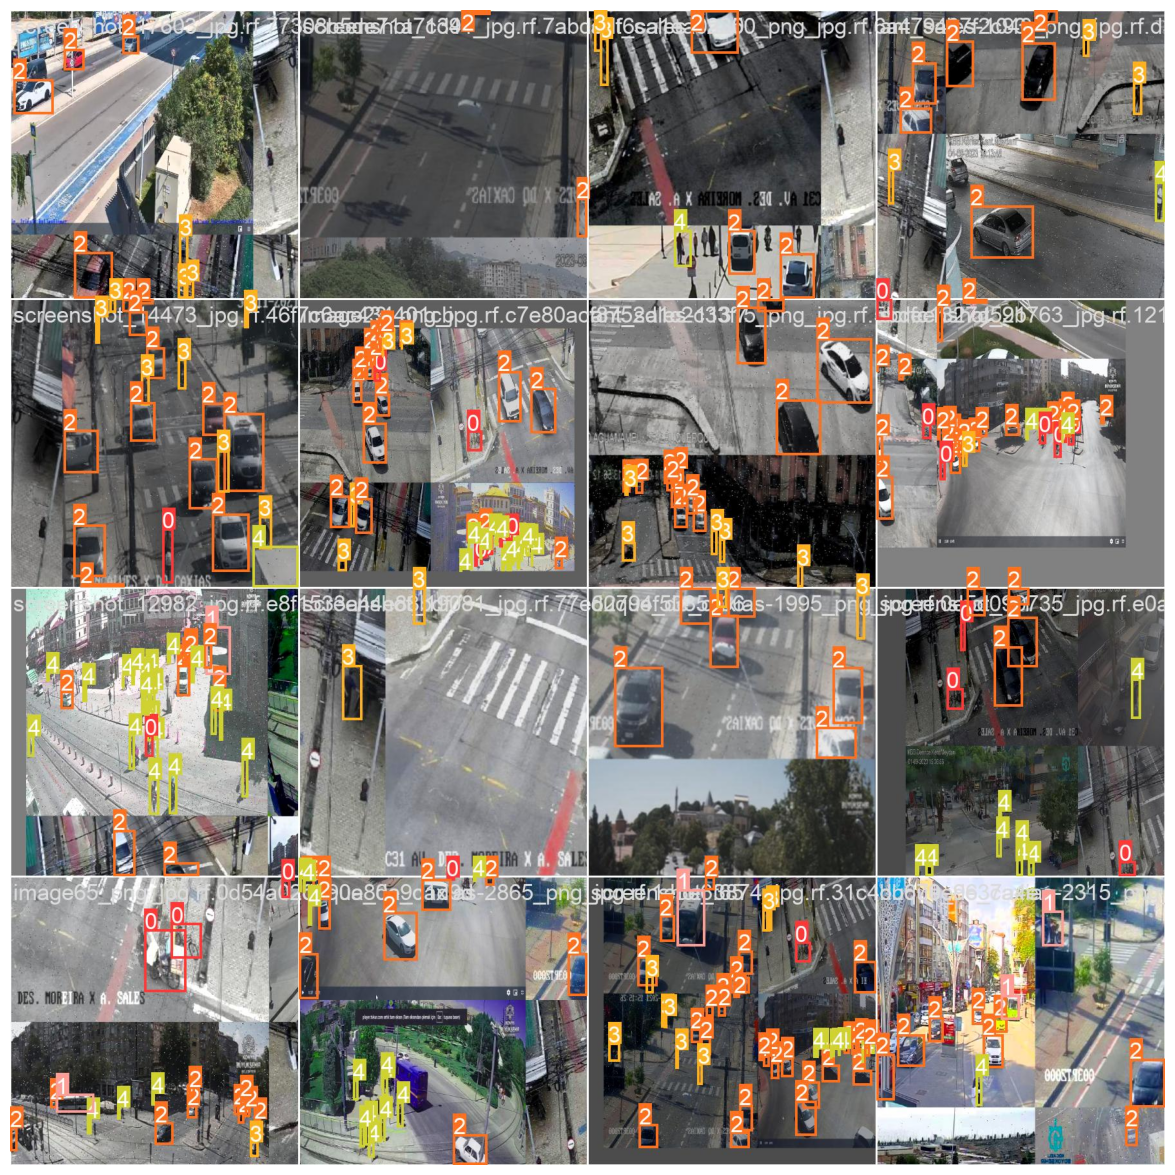

In [11]:
img = plt.imread('runs/train/yolov5m_results/train_batch0.jpg')
plt.figure(figsize=(20,15))
plt.imshow(img)
plt.axis('off')
plt.show()

In [12]:
!python detect.py --source /kaggle/input/traffic-detection-project/test/images/ --weight runs/train/yolov5m_results/weights/best.pt --name expTestImage --conf 0.4

detect: weights=['runs/train/yolov5m_results/weights/best.pt'], source=/kaggle/input/traffic-detection-project/test/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=expTestImage, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-230-g53efd07 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5m summary: 212 layers, 20869098 parameters, 0 gradients, 47.9 GFLOPs
image 1/279 /kaggle/input/traffic-detection-project/test/images/aguanambi-1000_png_jpg.rf.7179a0df58ad6448028bc5bc21dca41e.jpg: 640x640 11 cars, 3 motorbikes, 27.0ms
image 2/279 /kaggle/input/traffic-detection-project/test/images/aguanambi-1095_png_jpg.rf.4d9f0370f1c09fb2a

In [13]:
color_dict = {
    'bicycle': (0, 255, 0),  # màu xanh lá cây
    'bus': (0, 0, 255),      # màu xanh dương
    'car': (255, 0, 0),      # màu đỏ
    'motorbike': (255, 255, 0), # màu vàng
    'person': (0, 255, 255)  # màu xanh lục
}

In [14]:
!ls /kaggle/working/yolov5/runs/detect/expTestImage

aguanambi-1000_png_jpg.rf.7179a0df58ad6448028bc5bc21dca41e.jpg
aguanambi-1095_png_jpg.rf.4d9f0370f1c09fb2a1d1666b155911e3.jpg
aguanambi-1100_png_jpg.rf.8b7574e1c4f3fd7b654c2a693404fd2d.jpg
aguanambi-1240_png_jpg.rf.7e110b54d205ef0537ddc5dec81a79c2.jpg
aguanambi-1540_png_jpg.rf.b8ea6dd9130d82a3b6163bc3aaa823d3.jpg
aguanambi-1680_png_jpg.rf.fede1a51e422cc8fd628a4846615f65f.jpg
aguanambi-2105_png_jpg.rf.913b43f78d50d1ac51dcf3e43cc7da2b.jpg
aguanambi-2125_png_jpg.rf.7ded3baa4a5760fe91f32e3dc0946b61.jpg
aguanambi-2250_png_jpg.rf.03ef2afb1ddf6d6fb42c62429ebbcea1.jpg
aguanambi-2420_png_jpg.rf.12949ad5e139564e761cd26f2cd07f3c.jpg
aguanambi-2555_png_jpg.rf.e8fe552acc205329ac459d1087eb0637.jpg
aguanambi-2670_png_jpg.rf.1287a75cc98666be54dfa494d7b2bfe8.jpg
aguanambi-2670_png_jpg.rf.60530a426ae98c3e8e6ffcad678cfdae.jpg
aguanambi-2680_png_jpg.rf.305f12470094eb2510b876de1b5f8eb4.jpg
aguanambi-2995_png_jpg.rf.2fa2f60b9d1c1250287a03624c83817b.jpg
aguanambi-3125_png_jpg.rf.c928762f63b976739588cd27f57fc

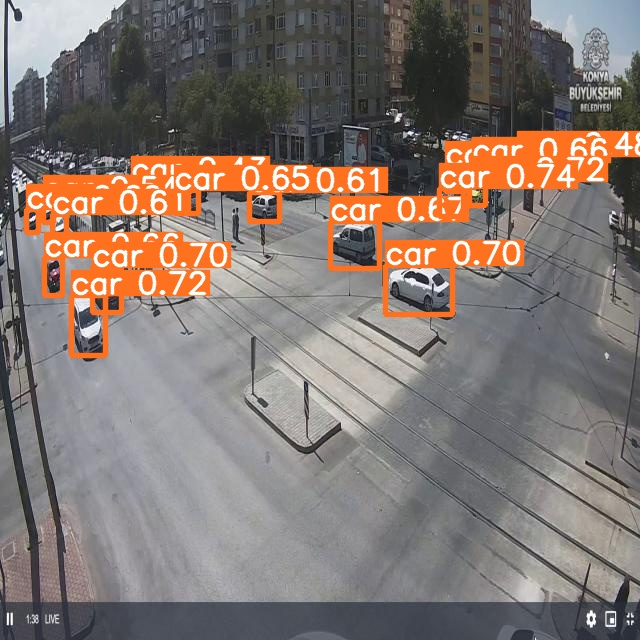

In [19]:
from PIL import Image
from glob import glob
all_path = glob("/kaggle/working/yolov5/runs/detect/expTestImage/*")
Image.open(all_path[1])

In [20]:
!pip3 install onnx>=1.10.0

In [22]:
input_width = 448 
input_height = 448 

!python3 export.py --weights runs/train/yolov5m_results2/weights/best.pt --img {input_height} {input_width} --batch 1 --include "onnx" --simplify

export: data=data/coco128.yaml, weights=['runs/train/yolov5m_results2/weights/best.pt'], imgsz=[448, 448], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=True, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v7.0-230-g53efd07 Python-3.10.12 torch-2.0.0 CPU

Fusing layers... 
custom_YOLOv5m summary: 212 layers, 20869098 parameters, 0 gradients, 47.9 GFLOPs

PyTorch: starting from runs/train/yolov5m_results2/weights/best.pt with output shape (1, 12348, 10) (40.2 MB)

ONNX: starting export with onnx 1.14.1...
================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

ONNX: simplifying with onnx-simplifier 0.4.35...
ONNX: export success ✅ 3.2s, saved as runs/train/yol

In [ ]:
1